In [2]:
# !pip install selectivesearch

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4349 sha256=3f0c3448af001ddd2f9a60173e8a89b26b5ba394efd93c7b007fdc5847474533
  Stored in directory: c:\users\wkddn\appdata\local\pip\cache\wheels\66\4e\88\6de23ce74be839a953498c4ebdfa809ad7da9422ac89ae856c
Successfully built selectivesearch


In [3]:
import selectivesearch
import cv2
import PIL
import requests
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import os
import xmltodict
from copy import deepcopy

import pandas as pd
import matplotlib.patches as mpatches

# Selective search

In [4]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=100, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < (0.01*img_area):
            continue
        if r['size'] > (0.99*img_area):
            continue
        # distorted rects
        x, y, w, h = r['rect']
    #     if w / h > 1.2 or h / w > 1.2:
    #         continue
        candidates.append(list(r['rect']))
    return candidates

In [5]:
#filename = jpegs + single_object_images[ix]
url = 'https://image.dongascience.com/Photo/2020/03/15856430426741.jpg'
img = PIL.Image.open(requests.get(url, stream=True).raw)
img = tf.keras.preprocessing.image.img_to_array(img)

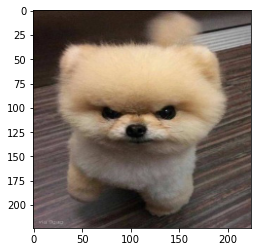

In [6]:
img = cv2.resize(img,(224,224))
img_area = img.shape[0]*img.shape[1]
candidates = extract_candidates(img)
plt.imshow(img/255)

In [7]:
candidates[:5]

[[58, 0, 60, 25],
 [148, 0, 75, 7],
 [27, 2, 55, 43],
 [93, 2, 88, 38],
 [163, 7, 60, 16]]

In [8]:
for x, y, w, h in candidates:
    img[y:(y+h), x, 1] = 1
    img[y:(y+h), (x+w), 1] = 1
    img[y, x:(x+w), 1] = 1
    img[y+h, x:(x+w), 1] = 1

x, y, w, h

    - left top width height?

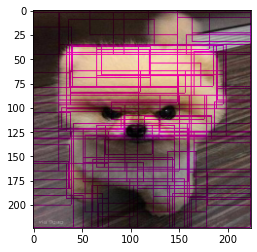

In [9]:
img = cv2.resize(img,(224,224))
img_area = img.shape[0]*img.shape[1]
candidates = extract_candidates(img)
plt.imshow(img/255)

# Read data from XML

In [10]:
xmls_root ="VOC2012_small/"  # Path to the root folder of rtaining data to be provided here
annotations = xmls_root + "Annotations/"
jpegs = xmls_root + "JPEGImages/"
XMLs = os.listdir(annotations)
print(XMLs[:10]); print(len(XMLs))

['2007_000027.xml', '2007_000032.xml', '2007_000033.xml', '2007_000039.xml', '2007_000042.xml', '2007_000061.xml', '2007_000063.xml', '2007_000068.xml', '2007_000121.xml', '2007_000123.xml']
17


# XML data

In [11]:
ix = np.random.randint(len(XMLs))
sample_xml = XMLs[ix]
sample_xml = '{}/{}'.format(annotations, sample_xml)
with open(sample_xml, "rb") as f:    # notice the "rb" mode
    d = xmltodict.parse(f, xml_attribs=True)

d

OrderedDict([('annotation',
              OrderedDict([('folder', 'VOC2012'),
                           ('filename', '2007_000061.jpg'),
                           ('source',
                            OrderedDict([('database', 'The VOC2007 Database'),
                                         ('annotation', 'PASCAL VOC2007'),
                                         ('image', 'flickr')])),
                           ('size',
                            OrderedDict([('width', '500'),
                                         ('height', '333'),
                                         ('depth', '3')])),
                           ('segmented', '1'),
                           ('object',
                            [OrderedDict([('name', 'boat'),
                                          ('pose', 'Unspecified'),
                                          ('truncated', '0'),
                                          ('difficult', '0'),
                                          ('bndbox',
 

In [12]:
def extract_iou2(candidate, current_y, img_shape):
    boxA = deepcopy(candidate)
    boxB = deepcopy(current_y)
    boxA[2] += boxA[0]
    boxA[3] += boxA[1]
    iou_img1 = np.zeros(img_shape)
    iou_img1[boxA[1]:boxA[3],boxA[0]:boxA[2]]=1

    iou_img2 = np.zeros(img_shape)
    iou_img2[int(boxB[1]):int(boxB[3]),int(boxB[0]):int(boxB[2])]=1
    iou = np.sum(iou_img1*iou_img2)/(np.sum(iou_img1)+np.sum(iou_img2)-np.sum(iou_img1*iou_img2))
    return iou

In [13]:
vgg16_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

# selective search vs train data

In [14]:
training_data_size = N = 17

final_cls = []
final_delta = []
iou_list = []
imgs = []

for ix, xml in enumerate(XMLs):
    
    if(ix%50==0):
        print(ix)
            
    print('Extracted data from {} xmls...'.format(ix), end='\r')
    xml_file = annotations + xml
    fname = xml.split('.')[0]
   
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        xml = xmltodict.parse(f, xml_attribs=True)
        l = []
        
        if isinstance(xml["annotation"]["object"], list):
            #'let us ignore cases with multiple objects...'
            continue

        #'extracting coordinates...'
        bndbox = xml['annotation']['object']['bndbox']
        
        for key in bndbox:
            bndbox[key] = float(bndbox[key])
        x1, x2, y1, y2 = [bndbox[key] for key in ['xmin', 'xmax', 'ymin', 'ymax']]
        
        img_size = xml['annotation']['size']
        
        for key in img_size:
            img_size[key] = float(img_size[key])
        w, h = img_size['width'], img_size['height']

        #'converting pixel values from bndbox to fractions...'
        x1 /= w; x2 /= w; y1 /= h; y2 /= h
        label = xml['annotation']['object']['name']
        
        y = [x1, y1, x2-x1, y2-y1, label] # i.e., top-left x & y, width and height
        
        filename = jpegs+fname+'.jpg' # Path to the image files to be provided here
        
        img = cv2.resize(cv2.imread(filename), (224,224)) # since VGG's input shape is 224x224
        candidates = extract_candidates(img)
        
        for jx, candidate in enumerate(candidates):

            current_y2 = [int(i*224) for i in [x1,y1,x2,y2]] # [int(x1*224), int(y1*224), int(x2*224), int(y2*224)]

            iou = extract_iou2(candidate, current_y2, (224, 224))

            candidate_region_coordinates = c_x1, c_y1, c_w, c_h = np.array(candidate)/224

            dx = c_x1 - x1 
            dy = c_y1 - y1 
            dw = c_w - (x2-x1)
            dh = c_h - (y2-y1)

            final_delta.append([dx,dy,dw,dh])         

            if(iou>0.3):                    
                final_cls.append(label)
            else:
                final_cls.append('background')

            #"We'll predict our candidate crop using VGG"
            l = int(c_x1 * 224)
            r = int((c_x1 + c_w) * 224)
            t = int(c_y1 * 224)
            b = int((c_y1 + c_h) * 224)

            img2 = img[t:b,l:r,:3]
            img3 = cv2.resize(img2,(224,224))/255
            img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
            imgs.append(img4[0])
            
            iou_list.append(iou)

0
1/1 [==============================] - 0s 348ms/step


In [15]:
len(imgs)

572

In [16]:
imgs[0].shape

(7, 7, 512)

In [17]:
# 좌표
final_delta[0]

[-0.35802469135802467, -0.202, 0.03277483833039385, -0.18749999999999994]

In [18]:
final_cls[0]

'background'

In [19]:
final_cls

['background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'background',
 'person',
 'background',
 'background',
 'backgroun

In [20]:
targets = pd.DataFrame(final_cls, columns=['label'])
print(targets.head())
labels = pd.get_dummies(targets['label']).columns
print(labels[:5])
y_train = pd.get_dummies(targets['label']).values.astype(float)
print(y_train[:5])

        label
0  background
1  background
2  background
3  background
4  background
Index(['aeroplane', 'background', 'bird', 'person', 'sheep'], dtype='object')
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [21]:
x_train = np.array(imgs)
x_train.shape

(572, 7, 7, 512)

In [22]:
img3.shape

(224, 224, 3)

In [23]:
res = vgg16_model.predict(img3.reshape(1,224,224,3))

1/1 [==============================] - 0s 367ms/step


In [24]:
res.shape

(1, 7, 7, 512)

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, Cropping2D,  concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

model = Sequential()
model.add(Flatten(input_shape=((7,7,512))))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 12,849,159
Trainable params: 12,849,159
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_train.shape

(572, 7)

In [27]:
history = model.fit(x_train/x_train.max(), y_train, validation_split = 0.1, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
9/9 [==============================] - 3s 163ms/step - loss: 0.2751 - accuracy: 0.7490 - val_loss: 0.5670 - val_accuracy: 0.5345
Epoch 2/10
9/9 [==============================] - 1s 123ms/step - loss: 0.1439 - accuracy: 0.8560 - val_loss: 0.3955 - val_accuracy: 0.5345
Epoch 3/10
9/9 [==============================] - 1s 111ms/step - loss: 0.0832 - accuracy: 0.9280 - val_loss: 0.2644 - val_accuracy: 0.8448
Epoch 4/10
9/9 [==============================] - 1s 111ms/step - loss: 0.0545 - accuracy: 0.9572 - val_loss: 0.2543 - val_accuracy: 0.6724
Epoch 5/10
9/9 [==============================] - 1s 127ms/step - loss: 0.0386 - accuracy: 0.9728 - val_loss: 0.2087 - val_accuracy: 0.8793
Epoch 6/10
9/9 [==============================] - 1s 101ms/step - loss: 0.0295 - accuracy: 0.9767 - val_loss: 0.2029 - val_accuracy: 0.8103
Epoch 7/10
9/9 [==============================] - 1s 101ms/step - loss: 0.0251 - accuracy: 0.9805 - val_loss: 0.1895 - val_accuracy: 0.8793
Epoch 8/10
9/9 [====

In [28]:
def test_predictions(filename):
    img = cv2.resize(cv2.imread(filename), (224,224))
    candidates = extract_candidates(img)

    _, ax = plt.subplots(1, 2)

    ax[0].imshow(img)
    ax[0].grid('off')
    ax[0].set_title(filename.split('/')[-1])


    pred = []
    pred_class = []

    for ix, candidate in enumerate(candidates):

        l, t, w, h = np.array(candidate).astype(int)

        img2 = img[t:t+h,l:l+w,:3]
        img3 = cv2.resize(img2,(224,224))/255
        img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
        final_pred = model.predict(img4/x_train.max())
        pred.append(np.max(final_pred))
        pred_class.append(np.argmax(final_pred))

    pred = np.array(pred)
    pred_class = np.array(pred_class)

    pred2 = pred[pred_class!=1]
    pred_class2 = pred_class[pred_class!=1]

    candidates2 = np.array(candidates)[pred_class!=1]

    x, y, w, h = candidates2[np.argmax(pred2)]

    ax[1].set_title(labels[pred_class2[np.argmax(pred2)]])
    ax[1].imshow(img)
    ax[1].grid('off')
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=3)
    ax[1].add_patch(rect)

In [29]:
filename = jpegs + XMLs[0].replace('xml', 'jpg')
filename

'VOC2012_small/JPEGImages/2007_000027.jpg'

1/1 [==============================] - 0s 44ms/step


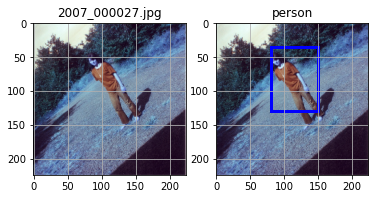

In [30]:
test_predictions(filename)